In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
generator_learning_rate = 0.0002
discriminator_learning_rate = 0.0002
num_epochs = 100
BATCH_SIZE = 128
LATENT_DIM = 100
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x



##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='dataset', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='dataset', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [4]:
##########################
### MODEL
##########################

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Reshape1(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 64, 7, 7)


class GAN(torch.nn.Module):

    def __init__(self):
        super(GAN, self).__init__()
        
        
        self.generator = nn.Sequential(
              
            nn.Linear(LATENT_DIM, 3136, bias=False),
            nn.BatchNorm1d(num_features=3136),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            Reshape1(),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=(2, 2), stride=(1, 1), padding=0, bias=False),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(in_channels=8, out_channels=32, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            #nn.Dropout2d(p=0.2),
            
            Flatten(),

            nn.Linear(7*7*32, 1),
            #nn.Sigmoid()
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = model.discriminator(img)
        return pred.view(-1)

In [5]:
torch.manual_seed(random_seed)

#del model
model = GAN()
model = model.to(device)

print(model)

GAN(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=3136, bias=False)
    (1): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.0001, inplace)
    (3): Reshape1()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.0001, inplace)
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.0001, inplace)
    (10): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.0001, inplace)
    (13): ConvTranspose2d(8, 1, kernel_size=(2, 2

In [6]:
optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

In [7]:
start_time = time.time()    

discr_costs = []
gener_costs = []
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        
        # Normalize images to [-1, 1] range
        features = (features - 0.5)*2.
        features = features.view(-1, IMG_SIZE).to(device) 

        targets = targets.to(device)

        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)
        

        ### FORWARD AND BACK PROP
        
        
        # --------------------------
        # Train Generator
        # --------------------------
        
        # Make new images
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(z)
        
        # Loss for fooling the discriminator
        discr_pred = model.discriminator_forward(generated_features.view(targets.size(0), 1, 28, 28))
        
        gener_loss = F.binary_cross_entropy_with_logits(discr_pred, valid)
        
        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()
        
        # --------------------------
        # Train Discriminator
        # --------------------------        
        
        discr_pred_real = model.discriminator_forward(features.view(targets.size(0), 1, 28, 28))
        real_loss = F.binary_cross_entropy_with_logits(discr_pred_real, valid)
        
        discr_pred_fake = model.discriminator_forward(generated_features.view(targets.size(0), 1, 28, 28).detach())
        fake_loss = F.binary_cross_entropy_with_logits(discr_pred_fake, fake)
        
        discr_loss = 0.5*(real_loss + fake_loss)

        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()        
        
        discr_costs.append(discr_loss.item())
        gener_costs.append(gener_loss.item())
        
        
        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), gener_loss, discr_loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Batch 000/469 | Gen/Dis Loss: 0.7258/0.7058
Epoch: 001/100 | Batch 100/469 | Gen/Dis Loss: 0.7567/0.5799
Epoch: 001/100 | Batch 200/469 | Gen/Dis Loss: 0.8557/0.5516
Epoch: 001/100 | Batch 300/469 | Gen/Dis Loss: 0.8770/0.5584
Epoch: 001/100 | Batch 400/469 | Gen/Dis Loss: 0.9160/0.5445
Time elapsed: 0.07 min
Epoch: 002/100 | Batch 000/469 | Gen/Dis Loss: 0.9623/0.5061
Epoch: 002/100 | Batch 100/469 | Gen/Dis Loss: 0.8869/0.5280
Epoch: 002/100 | Batch 200/469 | Gen/Dis Loss: 0.8702/0.5756
Epoch: 002/100 | Batch 300/469 | Gen/Dis Loss: 0.8495/0.5651
Epoch: 002/100 | Batch 400/469 | Gen/Dis Loss: 0.8599/0.5471
Time elapsed: 0.15 min
Epoch: 003/100 | Batch 000/469 | Gen/Dis Loss: 0.8148/0.5918
Epoch: 003/100 | Batch 100/469 | Gen/Dis Loss: 0.8370/0.5667
Epoch: 003/100 | Batch 200/469 | Gen/Dis Loss: 0.8154/0.6130
Epoch: 003/100 | Batch 300/469 | Gen/Dis Loss: 0.8170/0.6043
Epoch: 003/100 | Batch 400/469 | Gen/Dis Loss: 0.8336/0.6025
Time elapsed: 0.22 min
Epoch: 004/100 |

Epoch: 026/100 | Batch 000/469 | Gen/Dis Loss: 0.7997/0.6503
Epoch: 026/100 | Batch 100/469 | Gen/Dis Loss: 0.7557/0.6505
Epoch: 026/100 | Batch 200/469 | Gen/Dis Loss: 0.8059/0.6442
Epoch: 026/100 | Batch 300/469 | Gen/Dis Loss: 0.8019/0.6470
Epoch: 026/100 | Batch 400/469 | Gen/Dis Loss: 0.8598/0.6462
Time elapsed: 1.91 min
Epoch: 027/100 | Batch 000/469 | Gen/Dis Loss: 0.8436/0.6341
Epoch: 027/100 | Batch 100/469 | Gen/Dis Loss: 0.8188/0.6326
Epoch: 027/100 | Batch 200/469 | Gen/Dis Loss: 0.7646/0.6371
Epoch: 027/100 | Batch 300/469 | Gen/Dis Loss: 0.7791/0.6510
Epoch: 027/100 | Batch 400/469 | Gen/Dis Loss: 0.8036/0.6817
Time elapsed: 1.98 min
Epoch: 028/100 | Batch 000/469 | Gen/Dis Loss: 0.8114/0.6465
Epoch: 028/100 | Batch 100/469 | Gen/Dis Loss: 0.8550/0.6551
Epoch: 028/100 | Batch 200/469 | Gen/Dis Loss: 0.8643/0.6381
Epoch: 028/100 | Batch 300/469 | Gen/Dis Loss: 0.7337/0.6541
Epoch: 028/100 | Batch 400/469 | Gen/Dis Loss: 0.7800/0.6041
Time elapsed: 2.05 min
Epoch: 029/100 |

Epoch: 051/100 | Batch 000/469 | Gen/Dis Loss: 0.7089/0.6758
Epoch: 051/100 | Batch 100/469 | Gen/Dis Loss: 0.7356/0.6780
Epoch: 051/100 | Batch 200/469 | Gen/Dis Loss: 0.7275/0.6805
Epoch: 051/100 | Batch 300/469 | Gen/Dis Loss: 0.7679/0.6893
Epoch: 051/100 | Batch 400/469 | Gen/Dis Loss: 0.7102/0.6934
Time elapsed: 3.73 min
Epoch: 052/100 | Batch 000/469 | Gen/Dis Loss: 0.6917/0.7057
Epoch: 052/100 | Batch 100/469 | Gen/Dis Loss: 0.6797/0.7026
Epoch: 052/100 | Batch 200/469 | Gen/Dis Loss: 0.7559/0.6662
Epoch: 052/100 | Batch 300/469 | Gen/Dis Loss: 0.7416/0.7003
Epoch: 052/100 | Batch 400/469 | Gen/Dis Loss: 0.7179/0.6804
Time elapsed: 3.81 min
Epoch: 053/100 | Batch 000/469 | Gen/Dis Loss: 0.7675/0.6493
Epoch: 053/100 | Batch 100/469 | Gen/Dis Loss: 0.7516/0.6817
Epoch: 053/100 | Batch 200/469 | Gen/Dis Loss: 0.7419/0.6898
Epoch: 053/100 | Batch 300/469 | Gen/Dis Loss: 0.7470/0.6668
Epoch: 053/100 | Batch 400/469 | Gen/Dis Loss: 0.7345/0.6749
Time elapsed: 3.88 min
Epoch: 054/100 |

Epoch: 076/100 | Batch 000/469 | Gen/Dis Loss: 0.6882/0.7072
Epoch: 076/100 | Batch 100/469 | Gen/Dis Loss: 0.7275/0.6897
Epoch: 076/100 | Batch 200/469 | Gen/Dis Loss: 0.6844/0.6938
Epoch: 076/100 | Batch 300/469 | Gen/Dis Loss: 0.7054/0.6962
Epoch: 076/100 | Batch 400/469 | Gen/Dis Loss: 0.7250/0.7020
Time elapsed: 5.57 min
Epoch: 077/100 | Batch 000/469 | Gen/Dis Loss: 0.7030/0.6856
Epoch: 077/100 | Batch 100/469 | Gen/Dis Loss: 0.6856/0.7005
Epoch: 077/100 | Batch 200/469 | Gen/Dis Loss: 0.6788/0.7006
Epoch: 077/100 | Batch 300/469 | Gen/Dis Loss: 0.7146/0.6934
Epoch: 077/100 | Batch 400/469 | Gen/Dis Loss: 0.7459/0.6755
Time elapsed: 5.65 min
Epoch: 078/100 | Batch 000/469 | Gen/Dis Loss: 0.6765/0.7017
Epoch: 078/100 | Batch 100/469 | Gen/Dis Loss: 0.7469/0.6830
Epoch: 078/100 | Batch 200/469 | Gen/Dis Loss: 0.7327/0.6959
Epoch: 078/100 | Batch 300/469 | Gen/Dis Loss: 0.7395/0.6911
Epoch: 078/100 | Batch 400/469 | Gen/Dis Loss: 0.7053/0.6963
Time elapsed: 5.72 min
Epoch: 079/100 |

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

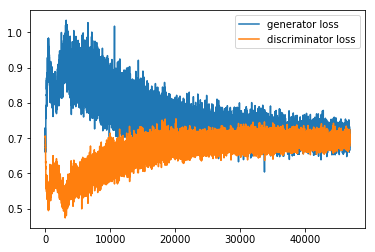

In [9]:
plt.plot(range(len(gener_costs)), gener_costs, label='generator loss')
plt.plot(range(len(discr_costs)), discr_costs, label='discriminator loss')
plt.legend()
plt.show()

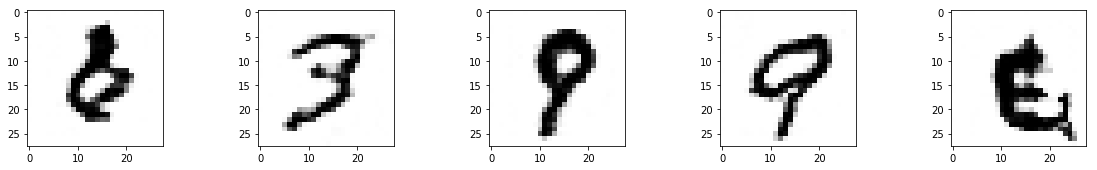

In [10]:
##########################
### VISUALIZATION
##########################


model.eval()
# Make new images
z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')